In [1]:
import cv2
import datetime
import matplotlib
import matplotlib.pyplot as plt
import imutils
%matplotlib inline

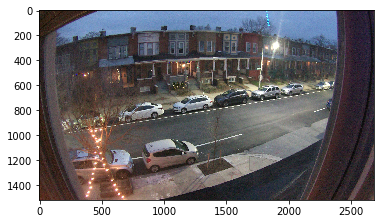

In [2]:
cal_path = "mounted-cars/calibration.jpg"
cal = cv2.flip(cv2.imread(cal_path), -1 ) #read & flip
plt.imshow(cv2.cvtColor(cal, cv2.COLOR_BGR2RGB))

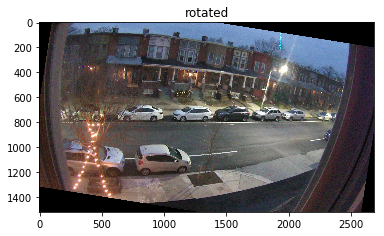

In [3]:
ROTATE_ANGLE = -9
rotated_cal = imutils.rotate(cal, angle=ROTATE_ANGLE) # rotate
plt.imshow(cv2.cvtColor(rotated_cal, cv2.COLOR_BGR2RGB))
plt.title("rotated");

Text(0.5, 1.0, 'calibration road')

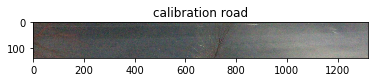

In [4]:
def crop_and_rotate(im):
    rotated = imutils.rotate(im, angle=ROTATE_ANGLE) # rotate
    return rotated[810:950, 680:2000] # clip
cal_rotated = crop_and_rotate(cal)
plt.imshow(cv2.cvtColor(cal_rotated, cv2.COLOR_BGR2RGB))
plt.title('calibration road')

In [5]:
import numpy as np
car_p1 = np.array([745, 881])
car_p2 = np.array([900, 856])
car_length_px = np.linalg.norm(car_p2 - car_p1)
px_2_m = lambda px: 1.93 * (px / car_length_px)
m_2_px = lambda m: (m / 1.93) * car_length_px
print("pixels per meter= {}".format(m_2_px(1)))
mps_2_mph = lambda mps: mps * 2.23694

pixels per meter= 81.34880035288904


In [14]:
import dateutil.parser

# for two frames
paths=[
    'mounted-cars/2018-12-27T17:07:10.167307.jpg',
    'mounted-cars/2018-12-27T17:07:10.792036.jpg',
]

# compare the time
def parse_time(path):
    time_s = path.split("mounted-cars/")[1][:-4]
    return dateutil.parser.parse(time_s)

t0 = parse_time(paths[0])
t1 = parse_time(paths[1])

# def subtract_bg(roi, cal):
#     return roi - cal

# TOO_HIGH = 250
# def low_pass(no_bg):
#     no_bg[no_bg > TOO_HIGH] = 0 # filter out too high values
#     return no_bg

def read_road_image(path):
    im = cv2.imread(path)
    flipped = cv2.flip(im, -1)
    cropped = crop_and_rotate(flipped)
    return cropped

# find the max value (maybe headlight?)
def get_max(im):
    max_v, max_idx = 0, None
    shape = im.shape
    for r in range(0, shape[0]):
        for c in range(0, shape[1]):
            idx = (r, c)
            v = np.linalg.norm(im[idx])
            if v > max_v:
                max_v = v
                max_idx = idx
    return (max_idx, max_v)

delta_t = t1 - t0

# compute the distance
p0, v0 = get_max(read_road_image(paths[0]))
p1, v1 = get_max(read_road_image(paths[1]))

def report_speed(delta_t, p0, p1):
    print("in {} sec".format(delta_t.total_seconds()))
    delta_p_pixels = np.linalg.norm(np.array(p1) - np.array(p0))
    print("drove {:.1f} px".format(delta_p_pixels))

    delta_p_m = px_2_m(delta_p_pixels)
    print("drove {:.2f} m".format(delta_p_m))

    speed_m = delta_p_m / delta_t.total_seconds()
    print("car speed {:.2f} MPH".format(mps_2_mph(speed_m)))

report_speed(delta_t, p0, p1)

in 0.624729 sec
drove 250.6 px
drove 3.08 m
car speed 11.03 MPH


In [7]:
def debug_im(path):
    im = read_road_image(path)
    ax = plt.subplot()
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    p, v = get_max(im)
    r,c = p
    ax.set_title("max_pt={} value={}".format(p, v))
    ax.add_patch(matplotlib.patches.Rectangle((c, r), 10, 10, color='magenta'))

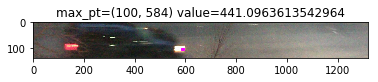

In [8]:
debug_im(paths[0])

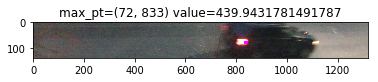

In [9]:
debug_im(paths[1])

In [16]:
report_speed(delta_t, p0, (72, 1120))

in 0.624729 sec
drove 536.7 px
drove 6.60 m
car speed 23.62 MPH


In [10]:
# tracker = cv2.TrackerKCF_create()
# tracker.update(read_roi_and_process(paths[0], None))